# Optimal Execution Problem: Liquidation

### Import the necessary libraries

In [ ]:
import numpy as np
import matplotlib
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt 

from tqdm import tqdm 

import time

In [ ]:
# import packages

import scipy.io as sio  # for loading matlab data

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model

In [ ]:
%matplotlib inline

### Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = sio.loadmat('/content/drive/My Drive/MLinFinance/MSFT_20141103.mat')

In [ ]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3  #time in seconds, measured from NASDAQ opening at 9:30am
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                       #total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                       #total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                #information about market orders
dt = t[1]-t[0]
print(dt)
print(t[0])
print(t[-1])

0.1
0.1
23400.0


### Visualisation Best Bid/Ask prices and Best Bid/Ask volumes

Ask price
Ask max is  47.46
Ask min is 46.74
Bid price
Bid Max is  47.45
Bid Min is  46.730000000000004


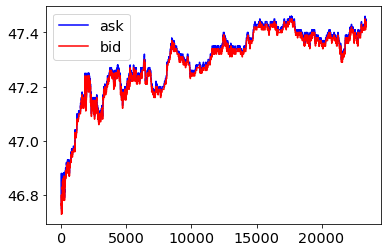

In [ ]:
plt.figure
plt.plot(t,ask[:,0],'b',label='ask')
plt.plot(t,bid[:,0],'r',label='bid')
plt.legend()

print("Ask price")
print("Ask max is ", max(ask[:,0]))
print("Ask min is", min(ask[:,0]))
print("Bid price")
print("Bid Max is ", max(bid[:,0]))
print("Bid Min is ", min(bid[:,0]))

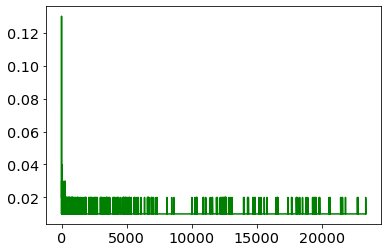

In [ ]:
plt.plot(t,ask[:,0]-bid[:,0],'g')

Ask volume
Ask max is  131105.0
Ask min is 5.0
Bid volume
Bid Max is  62159.0
Bid Min is  1.0


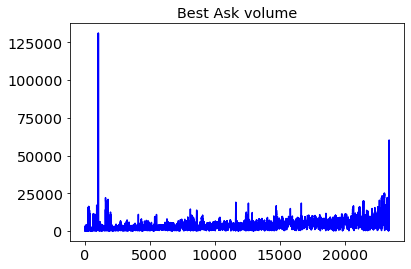

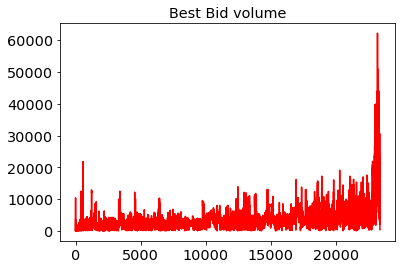

In [ ]:
plt.figure(1)
plt.plot(t,askvol[:,0],'b')
plt.title("Best Ask volume")
plt.figure(2)
plt.plot(t,bidvol[:,0],'r')
plt.title("Best Bid volume")

print("Ask volume")
print("Ask max is ", max(askvol[:,0]))
print("Ask min is", min(askvol[:,0]))
print("Bid volume")
print("Bid Max is ", max(bidvol[:,0]))
print("Bid Min is ", min(bidvol[:,0]))

[   3138.   11849.   10366. ... -461685. -462885. -462885.]


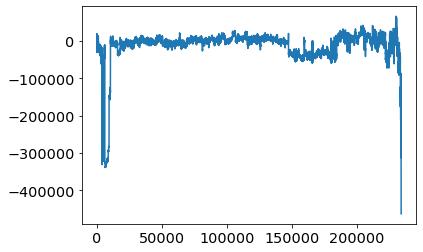

In [ ]:
# Order Flow
order_flow = np.sum(bidvol[:,:10],axis=1)-np.sum(askvol[:,:10],axis=1) # order flow: we take the first 10 columns
print(order_flow)
plt.plot(order_flow)

In [ ]:
# Midprice
midprice = 0.5*(bid[:,0]+ask[:,0])
print(midprice)

# Discretization in order to have a finite MDP

l = sorted(set(midprice))                                 # find number of only unique values to help choose the number of discretized values + sort
l = np.array(l)                                           # converting list to array
l_1 = np.arange(45.75, 46.735, 0.1)                       # adding certain values in case the execution price is lower than the min of the midprice
l_2 = np.arange(47.460, 48, 0.1)                          # adding certain values in case the execution price is greater than the max of the midprice
L = np.concatenate((l_1, l), axis=0)

L_discretized = np.concatenate((L, l_2), axis=0)
print(L_discretized)
print(len(L_discretized))

#tab_discretization = list(range(1,len(L_discretized)))
#print(tab_discretization)

[46.74  46.775 46.805 ... 47.435 47.435 47.435]
[45.75  45.85  45.95  46.05  46.15  46.25  46.35  46.45  46.55  46.65
 46.735 46.74  46.745 46.75  46.755 46.76  46.765 46.77  46.775 46.78
 46.785 46.785 46.79  46.795 46.8   46.8   46.805 46.81  46.815 46.815
 46.82  46.825 46.83  46.835 46.835 46.84  46.845 46.85  46.855 46.86
 46.865 46.87  46.875 46.88  46.885 46.89  46.895 46.9   46.905 46.91
 46.915 46.92  46.925 46.93  46.935 46.945 46.95  46.955 46.96  46.965
 46.97  46.975 46.985 46.99  46.995 47.    47.005 47.015 47.02  47.025
 47.035 47.045 47.055 47.06  47.065 47.07  47.075 47.08  47.085 47.09
 47.095 47.1   47.105 47.11  47.115 47.12  47.125 47.13  47.135 47.14
 47.145 47.15  47.155 47.16  47.165 47.17  47.175 47.18  47.185 47.19
 47.195 47.2   47.205 47.21  47.215 47.22  47.225 47.23  47.235 47.24
 47.245 47.25  47.255 47.26  47.265 47.27  47.275 47.28  47.285 47.29
 47.295 47.3   47.305 47.31  47.315 47.32  47.325 47.33  47.335 47.34
 47.345 47.35  47.355 47.36  47.365 47.

### Setting Up the Market Impact Problem

We assume $N$ number of shares to liquidate, $M$ possible mid-prices and $T$ time steps. All combinations of state and time can then be represented as a four-dimensional grid of size $N_1\times M\times T$. A time-dependent action-value function $ Q_t(s_t, a_t)$ with $N_2$ possible actions can then be stored as a rank-four tensor of dimension $N_1\times M\times T \times N_2$. 

#### Setting some global parameters

Trading Window: 13:01 to 15:30

In [ ]:
# First, we work with the time and the trading window we chose

t_init = (211*10*60)-1         # time for 13:01 am
t_30_min = 30*10*60            # 30 minutes: we trade from 13:01 to the (end-30) minutes
N = 10*60                      # Length of estimation window

total_time = len(t)
trading_time = t[t_init:total_time-t_30_min]
trading_time = trading_time[::10]
print(total_time)
print(trading_time)
print(len(trading_time))

trading_time_indx = trading_time - trading_time[0]
trading_time_indx = [ int(x) for x in trading_time ] #[int(x) for x in len(trading_time)]
print(trading_time_indx)
end_trading = trading_time_indx[-1]
print(end_trading)

T0 = trading_time_indx[0]

234000
[12660. 12661. 12662. ... 21598. 21599. 21600.]
8941
[12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 1

Exploration on the trading window without our impact

MO volumes
[  700.  4352. 11078.  6619.  7370. 11664.  2400.  3500.  4200.  2800.
  1800.  4200.  2100.  2600.  1360.  5000.  1100.  4150.  1500.  4000.]
[ 6180.  6038.  6105.  5224.  3862.  6193.  7000.  1800.  3820.  1820.
  3769.  1927.  4515. 46373.  2580.  3654.  1300.  2300.  1841.  6217.]


Text(0.5, 1.0, 'MO volumes from the beginning of the trading window')

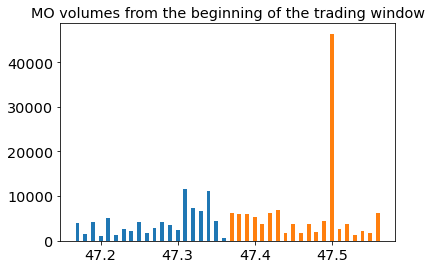

In [ ]:
print('MO volumes')
print(bidvol[t_init+1,:])
print(askvol[t_init+1,:])
plt.bar(bid[t_init+1,:],bidvol[t_init+1,:],width=0.005)
plt.bar(ask[t_init+1,:],askvol[t_init+1,:],width=0.005)
plt.show
plt.title("MO volumes from the beginning of the trading window")

Text(0.5, 1.0, 'Evolution of the order flow on the trading window')

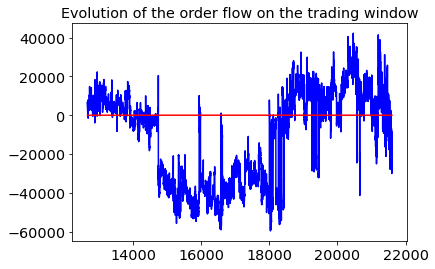

In [ ]:
# order flow on the trading window
mean_OF_TW = np.mean(order_flow[t_init:total_time-t_30_min])

plt.figure(1)
plt.plot(t[t_init:total_time-t_30_min],order_flow[t_init:total_time-t_30_min],'b')
plt.plot(t[t_init:total_time-t_30_min:10],np.zeros(len(trading_time)),'r')
plt.title('Evolution of the order flow on the trading window')

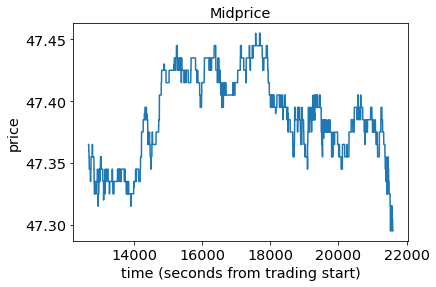

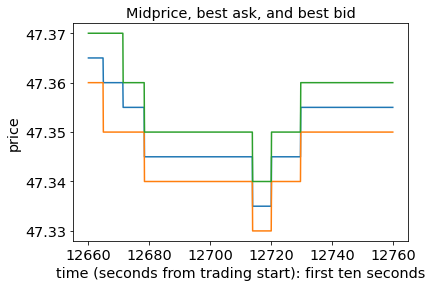

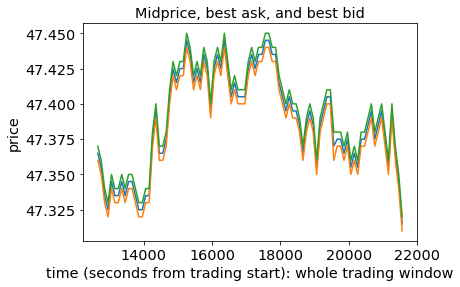

In [ ]:
# Evolution of the midprice on the trading window

plt.figure(1)
plt.plot(t[t_init:total_time-t_30_min],midprice[t_init:total_time-t_30_min])
plt.title('Midprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

plt.figure(2)
plt.plot(t[t_init:t_init+1000],midprice[t_init:t_init+1000])
plt.plot(t[t_init:t_init+1000],bid[t_init:t_init+1000,0])
plt.plot(t[t_init:t_init+1000],ask[t_init:t_init+1000,0])
plt.title('Midprice, best ask, and best bid')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start): first ten seconds')
plt.show()

plt.figure(3)
plt.plot(t[t_init:total_time-t_30_min:1000],midprice[t_init:total_time-t_30_min:1000])
plt.plot(t[t_init:total_time-t_30_min:1000],bid[t_init:total_time-t_30_min:1000,0])
plt.plot(t[t_init:total_time-t_30_min:1000],ask[t_init:total_time-t_30_min:1000,0])
plt.title('Midprice, best ask, and best bid')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start): whole trading window')
plt.show()


In [ ]:
BLOCK_SIZE = 40                     # number of shares in a bloc
NUM_BLOCKS = 50                     # initial number of blocks
NUM_S      = len(L_discretized)     # number of discrete values of S
NUM_TIME_STEPS = len(trading_time)  # total number of seconds
dt         = 1                      # time step: check every second
lmbda      = 0.01                   # risk aversion parameter: to be tested with different values then
p_star1    = 0.01                   # p-values authorized
p_star2    = 0.05                   # p-values authorized
sigma_stock = 0.1

np.random.seed(0)                   #setting random seed

In [ ]:
EPSILON = 0.1       # Probability for exploration
ALPHA = 0.5         # Step size
GAMMA = 1           # Discount factor for Q-Learning and Sarsa

In [ ]:
S0 = (ask[t_init,0]+bid[t_init,0])/2  # initial midprice
print(S0)
diff_S0 = np.absolute(L_discretized-S0)
S0_index = diff_S0.argmin()
print(S0_index)

47.365
134


We define the list of possible actions; which is selling a discretized quantity in [0,100000].

In [ ]:
ACTIONS = list(range(0,5))
print(ACTIONS)

[0, 1, 2, 3, 4]


We define the state vector for the initial state: the maximum number of stocks, the initial price $S_0$, and time $t = 0$

In [ ]:
START = [NUM_BLOCKS -1, S0_index, 0]

Step function that describes how the next state is obtained from the current state and the action taken. The function returns the next state and the reward obtained.

In [ ]:
def step(state, action):
    reward = 0
    cash = 0
    X, S_index, time_t = state
    
    # You can't sell more stock than you have
    if action > X: 
        action = X
    
    # Calculate the number of stocks remaining: X_next
    X_next = X - action
    
    ## Calculate the resulting price movement
    # Estimating S_next thanks to information on the order flow

    estimation_midprice = midprice[int(trading_time[time_t]-N):int(trading_time[time_t])]     # Backtesting on the previous minute: estimation window for midprice
    S_hat = estimation_midprice[::10]                                                         # Focus on every 10th entry

    estimation_OF = order_flow[int(trading_time[time_t]-N):int(trading_time[time_t])]         # Backtesting on the previous minute: estimation window for order flow
    OF_hat = estimation_OF[::10]                                                              # Reduced frequency

    OF_hat[-1] = OF_hat[-1] - action*BLOCK_SIZE
    OF_tilde = OF_hat - np.mean(OF_hat)                       # Order flow centered

    order_flow[int(trading_time[time_t]):end_trading] = order_flow[int(trading_time[time_t]):end_trading] - action*BLOCK_SIZE #YZ: the influence of our trades to order flow should be permanent
    
    phi, sigma = linear_model.yule_walker(OF_tilde,order=1)     # Yules-Walker equation
    my_DF = stattools.adfuller(OF_tilde,1,'c',None)             # Dickey-Fuller test
    p_value1 = (my_DF[1])

    price_impact, intercept, r_value, p_value2, std_err = stats.linregress(np.diff(OF_hat),np.diff(S_hat))  

    if p_value1<p_star1 and p_value2<p_star2 and price_impact>0:
      # GOOD STATISTICAL ENVIRONMENT
      alpha = -price_impact*OF_tilde[-1]*(1-phi[0])       # expected change predicted with the price impact
      S_execution  = L_discretized[S_index] + alpha            # estimation of St+1: execution price = current price - expected change predicted with the price impact
      if OF_hat[-1] < 0 and action >= 0:
        reward = +10000
      if OF_hat[-1] > 0 and action > 0:
        reward = -500 
    else:
      # BAD STATISTICAL ENVIRONMENT
      alpha = -price_impact*OF_tilde[-1]*(1-phi[0])
      S_execution = L_discretized[S_index] + alpha           
      if action != 0:
        reward = -1000
      else:
        reward = +5000  
    
    cash = S_execution*action*BLOCK_SIZE #YZ: for accumalted cash earnings
    
    S_next = S_execution*np.exp(sigma_stock*np.random.randn()) #YZ: introduce the randomness


    # Quantise S_next to an allowed value
    S_next = np.around(S_next, decimals=3)
    difference_array = np.absolute(L_discretized-S_next)
    S_index = difference_array.argmin()
    
    next_state = [X_next, S_index, time_t+dt]
    
    # Calculate the reward earned from the sale  
    #reward += BLOCK_SIZE*action*L_discretized[S_index] - lmbda*BLOCK_SIZE*X_next**2     # NOT SURE HERE for the second term
    reward += BLOCK_SIZE*action*L_discretized[S_index] - lmbda*BLOCK_SIZE*X_next**2*(S_execution**2*(np.exp(sigma_stock**2)-1))
    
    return next_state, reward, cash

In [ ]:
# Check some state, action pairs and the associated reward
print(step(START, 0))
print(step([20,100,110], 2))

([49, 157, 1], -16653.823902768825, 0.0)
([18, 157, 111], -64.34728878513306, 3775.597886446597)


### Set up the agent's action policy

Given $S_t$ and $Q_t\left( s_t, a_t\right)$, this function chooses an action based on the epsilon-greedy algorithm

In [ ]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # With probability `eps', simply choose a random action - 'Exploration'
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    # Otherwise, choose from the actions with the highest
    # q-value for the given state - 'Exploitation'
    else:
        values_ = q_value[state[0], state[1], state[2], :]
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # You cannot sell more stocks than you have
    if action > state[0]:
        action = state[0]
    
    return action

For example, when `q_value` is all zeroes, the action taken is always random:

In [ ]:
#q_value = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS)))
#[choose_action(START, q_value, EPSILON) for i in range(21)]

### Set up the learning algorithms

#### Sarsa and Expected Sarsa

This function simulates an episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [ ]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    total_cash = 0.0 #YZ: accumulate cash earnings during the whole trading period
    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        next_state, reward, cash = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        total_cash += cash #YZ: accumulate cash earnings during the whole trading period
        if not expected:
            target = q_value[next_state[0], next_state[1], next_state[2], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], next_state[2], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], next_state[2], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], next_state[2], action_]
        target *= GAMMA
        q_value[state[0], state[1], state[2], action] += step_size * (
                reward + target - q_value[state[0], state[1], state[2], action])
        state = next_state
        action = next_action
    #print("Rewards printed... '", rewards)    
    return rewards, total_cash

#### Cash after SARSA

Total cash after SARSA.

In [ ]:
def sarsa_cash(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    total_cash = 0.0 #YZ: accumulate cash earnings during the whole trading period
    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        next_state, reward, cash = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        total_cash += cash #YZ: accumulate cash earnings during the whole trading period
        if not expected:
            target = q_value[next_state[0], next_state[1], next_state[2], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], next_state[2], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], next_state[2], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], next_state[2], action_]
        target *= GAMMA
        q_value[state[0], state[1], state[2], action] += step_size * (
                cash + target - q_value[state[0], state[1], state[2], action])
        state = next_state
        action = next_action
    #print("Rewards printed... '", rewards)    
    return rewards, total_cash

### Running Sarsa 

This function will plot the average (over `runs` independent trials) rewards earned by SARSA and Q-learning after each iteration (up to `episodes`).

In [ ]:
def figure_9_4(episodes=1000, runs=100):
    EPOCH=25
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)

    for r in tqdm(range(runs)):
        # Initialise the state-action arrays 
        q_sarsa = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS)))
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)[0]
    
    # Averaging over independent runs
    rewards_sarsa /= runs
    
    # Draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa',color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    return q_sarsa


In [ ]:
def figure_cash(episodes=1000, runs=100):
    EPOCH=25
    
    # Initialise the rewards arrays
    cash_sarsa = np.zeros(episodes) #YZ: total cash earnings for multiple episodes

    for r in tqdm(range(runs)):
        # Initialise the state-action arrays 
        q_sarsa_cash = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS, len(ACTIONS)))
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            cash_sarsa[i] += sarsa_cash(q_sarsa_cash, eps=eps)[1]
    
    # Averaging over independent runs
    cash_sarsa /= runs
    
    # Draw reward curves
    #plt.plot(cash_sarsa, label='Cash')
    #plt.xlabel('Episodes')
    #plt.ylabel('Cash gained process')
    #plt.legend()

    print('Optimal terminal cash gained is: ',np.mean(cash_sarsa[-100:]))

    return q_sarsa_cash


100%|██████████| 50/50 [1:01:56<00:00, 74.34s/it]


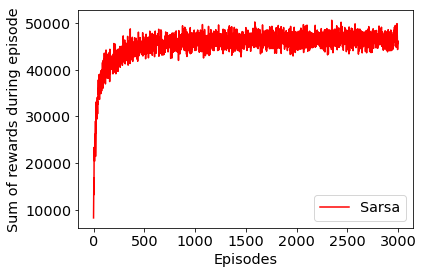

In [ ]:
q_sarsa = figure_9_4(3000, 50)

In [ ]:
cash = figure_cash(episodes=3000, runs=50)

Comparing with TWAP

94318.18364836804


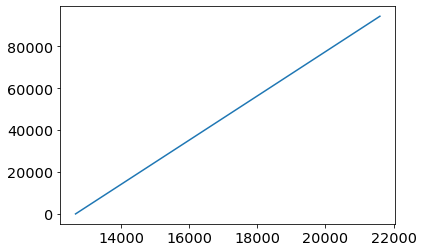

In [ ]:
Q0 = NUM_BLOCKS*BLOCK_SIZE
terminal_cash = []
cash_t = 0
for i in trading_time_indx:
    cash_t += (Q0/len(trading_time_indx))*midprice[i+1]
    terminal_cash.append(cash_t)

print(terminal_cash[-1])
plt.plot(trading_time_indx,terminal_cash)

Display the resulting optimal policies

In [ ]:
def print_optimal_policy(q_value):
    optimal_policy = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS))
    for i in range(0, NUM_BLOCKS):
        for j in range(0, NUM_S):
            for k in range(0, NUM_TIME_STEPS):
                optimal_policy[i,j,k] = np.argmax(q_value[i, j, k, :])
    for k in range(0, NUM_TIME_STEPS):
      print("========= time step " + str(k) + "======") 
      print(" price: 1,2,3,4,5,6,7,8,9,10,11,12,...")
      for i in range(0, NUM_BLOCKS):
        str_="inventory " + str(i) + ":"    
        for j in range(0, NUM_S): 
            str_+=str(np.int(optimal_policy[i,j,k])) + ','
        print(str_)    

In [ ]:
#print('Sarsa Optimal Policy:')
#print_optimal_policy(q_sarsa)
#print('Q-Learning Optimal Policy:')
#print_optimal_policy(q_q_learning)

In [ ]:
def my_optimal_policy(q_value):
  optimal_policy = np.zeros((NUM_BLOCKS, NUM_S, NUM_TIME_STEPS))
  for i in range(0, NUM_BLOCKS):
    for j in range(0, NUM_S):
      for k in range(0, NUM_TIME_STEPS):
        optimal_policy[i,j,k] = np.argmax(q_value[i, j, k, :])
  for k in range(0, NUM_TIME_STEPS):
      print("Time step: ",k)
      for i in range(0, NUM_BLOCKS):   
        for j in range(0, NUM_S): 
            if np.int(optimal_policy[i,j,k]) != 0:
              print("Printing when there is an action different from zero")
              print("inventory: ",i)
              print("price index: ",j)
              print("time step: ",k)
              print(np.int(optimal_policy[i,j,k]))    
             

In [ ]:
my_optimal_policy(q_sarsa)

Time step:  0
Printing when there is an action different from zero
inventory:  49
price index:  134
time step:  0
5
Time step:  1
Printing when there is an action different from zero
inventory:  40
price index:  134
time step:  1
3
Printing when there is an action different from zero
inventory:  41
price index:  134
time step:  1
2
Printing when there is an action different from zero
inventory:  42
price index:  134
time step:  1
1
Printing when there is an action different from zero
inventory:  43
price index:  134
time step:  1
8
Printing when there is an action different from zero
inventory:  44
price index:  134
time step:  1
9
Printing when there is an action different from zero
inventory:  45
price index:  134
time step:  1
1
Printing when there is an action different from zero
inventory:  46
price index:  134
time step:  1
9
Printing when there is an action different from zero
inventory:  47
price index:  134
time step:  1
9
Printing when there is an action different from zero
i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Time step:  3941
Time step:  3942
Time step:  3943
Time step:  3944
Time step:  3945
Time step:  3946
Time step:  3947
Time step:  3948
Time step:  3949
Time step:  3950
Time step:  3951
Time step:  3952
Time step:  3953
Time step:  3954
Time step:  3955
Time step:  3956
Time step:  3957
Time step:  3958
Time step:  3959
Time step:  3960
Time step:  3961
Time step:  3962
Time step:  3963
Time step:  3964
Time step:  3965
Time step:  3966
Time step:  3967
Time step:  3968
Time step:  3969
Time step:  3970
Time step:  3971
Time step:  3972
Time step:  3973
Time step:  3974
Time step:  3975
Time step:  3976
Time step:  3977
Time step:  3978
Time step:  3979
Time step:  3980
Time step:  3981
Time step:  3982
Time step:  3983
Time step:  3984
Time step:  3985
Time step:  3986
Time step:  3987
Time step:  3988
Time step:  3989
Time step:  3990
Time step:  3991
Time step:  3992
Time step:  3993
Time step:  3994
Time